# **Download the Data set From Kaggle**

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sathushanag","key":"24ed2c46bfc00c22f72898d93d683284"}'}

In [3]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# **Load the Data set**

In [4]:
!kaggle datasets download -d rishiksaisanthosh/brain-tumour-classification

Dataset URL: https://www.kaggle.com/datasets/rishiksaisanthosh/brain-tumour-classification
License(s): unknown


In [5]:
import zipfile

with zipfile.ZipFile("brain-tumour-classification.zip", "r") as zip_ref:
    zip_ref.extractall("brain-tumour-classification")

In [6]:
import os

dataset_path = "brain-tumour-classification/BrainTumor_1"
folders = os.listdir(dataset_path)
print("Folders in dataset:", folders)

Folders in dataset: ['Test', 'Train']


# **Data Preprocessing**

In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [8]:
import numpy as np

In [9]:
IMAGE_SIZE = 100
BATCH_SIZE = 16

In [10]:
CHANNELS = 3
EPOCHS = 30

In [11]:
train_datasets=tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/brain-tumour-classification/BrainTumor_1/Train',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 22848 files belonging to 4 classes.


In [12]:
test_datasets=tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/brain-tumour-classification/BrainTumor_1/Test',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


## **Data Visualization**

In [13]:
train_len = len(train_datasets)
test_len = len(test_datasets)

In [14]:
print("Length of Train dataset:",train_len)
print("Length of Test dataset:",test_len)

Length of Train dataset: 1428
Length of Test dataset: 82


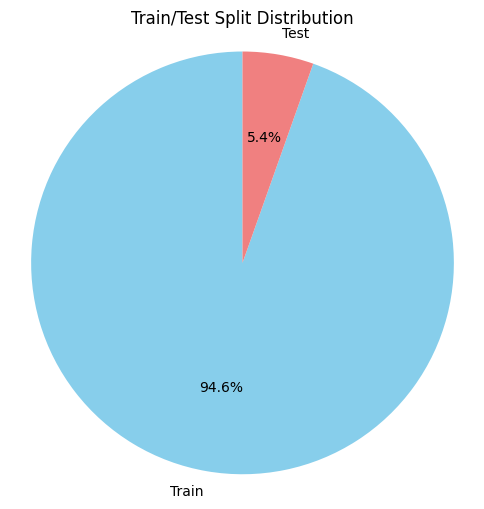

In [15]:
# Pie chart
labels = ['Train', 'Test']
sizes = [train_len, test_len]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Train/Test Split Distribution')
plt.axis('equal')
plt.show()

## **Seeing the class distribution in the train dataset**

In [16]:
class_names =train_datasets.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf

def show_class_distribution(dataset, title) -> None:
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)

    for images, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_counts[label] += 1


    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title(f'Class Distribution in {title}')
    plt.axis('equal')
    plt.show()


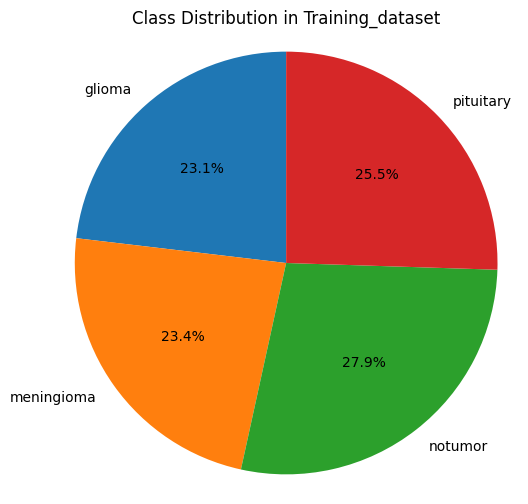

In [18]:
show_class_distribution(train_datasets,'Training_dataset')

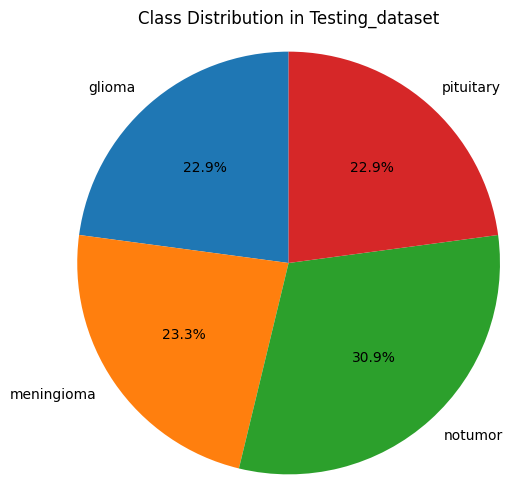

In [19]:
show_class_distribution(test_datasets,'Testing_dataset')

### **Visualize the data set**

In [20]:
for image_batch,label_batch in train_datasets.take(1):
  # print(image_batch[0].numpy())
  print(image_batch[0].shape)

(100, 100, 3)


In [21]:
def show_brain_tumor_images(dataset):
  plt.figure(figsize=(12,12))
  for image_batch,label_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(4,3,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(dataset.class_names[label_batch[i]])
      plt.axis("off")

#### **Training data**

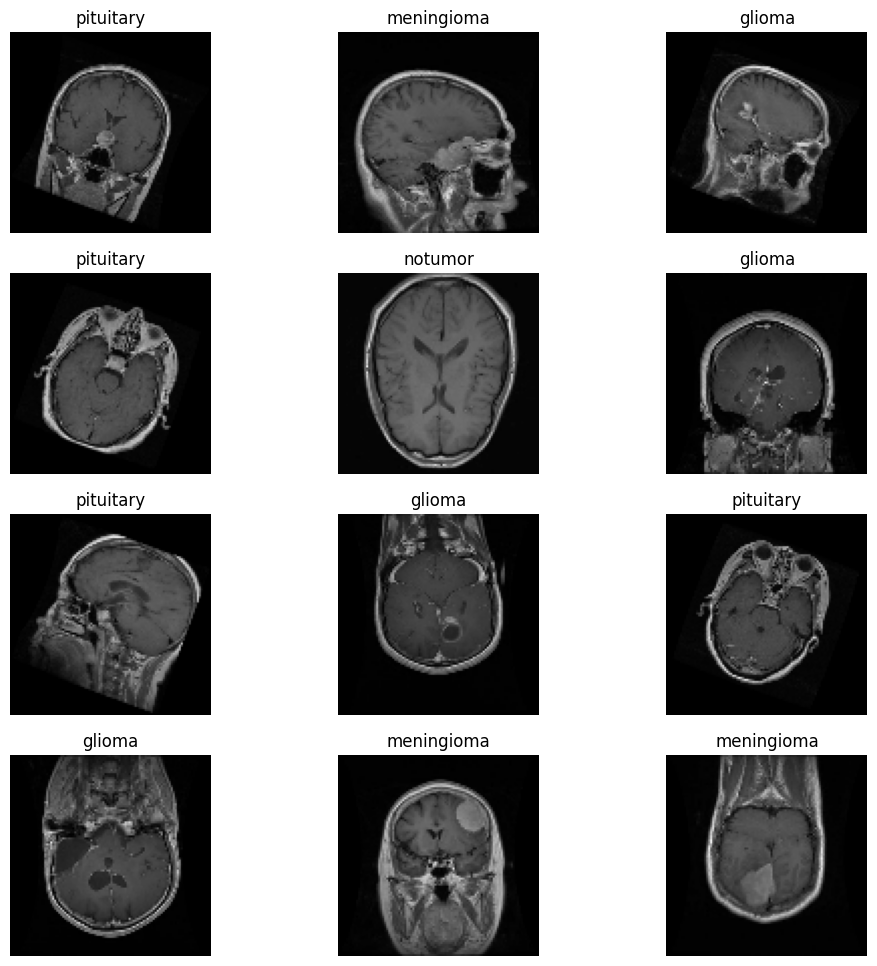

In [22]:
show_brain_tumor_images(train_datasets)

#### **Testing data**

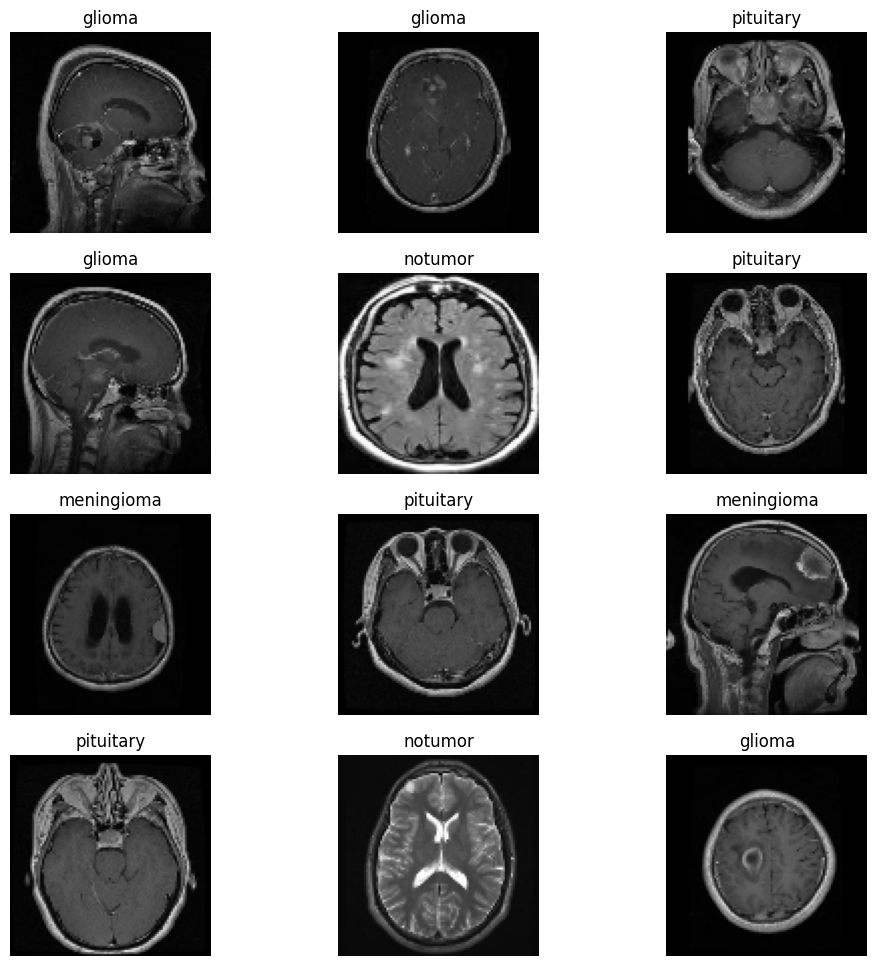

In [23]:
show_brain_tumor_images(test_datasets)

In [24]:
def get_dataset_partitions_tf(ds,val_split=0.5,shuffle=True,shuffle_size=1000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)


  val_size = int(ds_size*val_split)

  val_ds = ds.take(val_size)
  test_ds = ds.skip(val_size)

  return val_ds,test_ds

In [25]:
val_ds,test_ds = get_dataset_partitions_tf(train_datasets)
train_ds=train_datasets

In [26]:
len(test_ds),len(val_ds)

(714, 714)

In [27]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [29]:
data_augumentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1,fill_mode='nearest'),
    layers.RandomZoom(0.4),
    layers.RandomFlip('horizontal'),
    layers.RandomContrast(0.1),
    # layers.RandomBrightness(factor=(0.01,0.1))
])

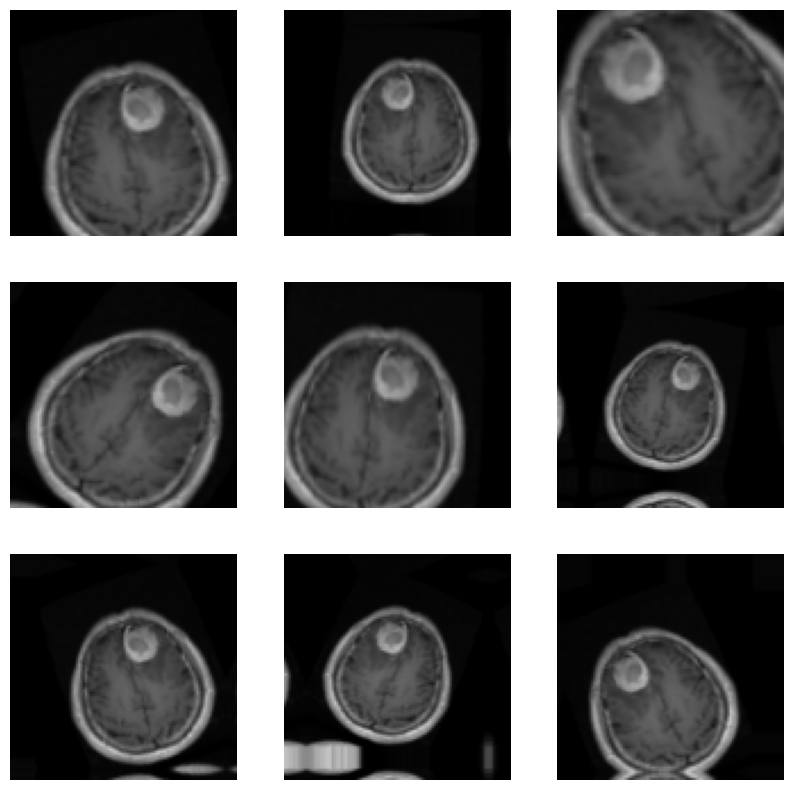

In [30]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augumentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# **Develop the CNN GRU RNN Model**

In [56]:
num_classes = 4

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model_rnn =tf.keras.Sequential([
        tf.keras.Input(shape= (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
        resize_and_rescale,
        data_augumentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
        layers.MaxPooling2D((2,2)),
        layers.Reshape((1,-1)),
        # layers.Flatten(),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
      ])

model_rnn.build()

In [57]:
model_rnn.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 1, 76832)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 128)            │    29,553,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,571,332 (112.81 MB)

 Trainable params: 29,571,332 (112.81 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
learning_rate = 0.00001

model_rnn.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history_rnn = model_rnn.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.4141 - loss: 1.2406 - val_accuracy: 0.4588 - val_loss: 1.1150
Epoch 2/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.5555 - loss: 1.0736 - val_accuracy: 0.4675 - val_loss: 1.1392
Epoch 3/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.5821 - loss: 1.0154 - val_accuracy: 0.4816 - val_loss: 1.1028
Epoch 4/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.5955 - loss: 0.9902 - val_accuracy: 0.4113 - val_loss: 1.2675
Epoch 5/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.6084 - loss: 0.9567 - val_accuracy: 0.4029 - val_loss: 1.3461
Epoch 6/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6183 - loss: 0.9334 - val_accuracy: 0.4073 - val_loss: 1.3416
Epoch 7/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6362 - loss: 0.9072 - val_accuracy: 0.3935 - val_loss: 1.4307
Epoch 8/30
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.6363 -

# **Evaluate the Model**

In [60]:
rnn_test_scores =  model_rnn.evaluate(test_ds)

714/714 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.3986 - loss: 1.7716


In [61]:
acc_rnn = history_rnn.history['accuracy']
val_acc_rnn = history_rnn.history['val_accuracy']
loss_rnn = history_rnn.history['loss']
val_loss_rnn= history_rnn.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss for \n GRU_RNN')

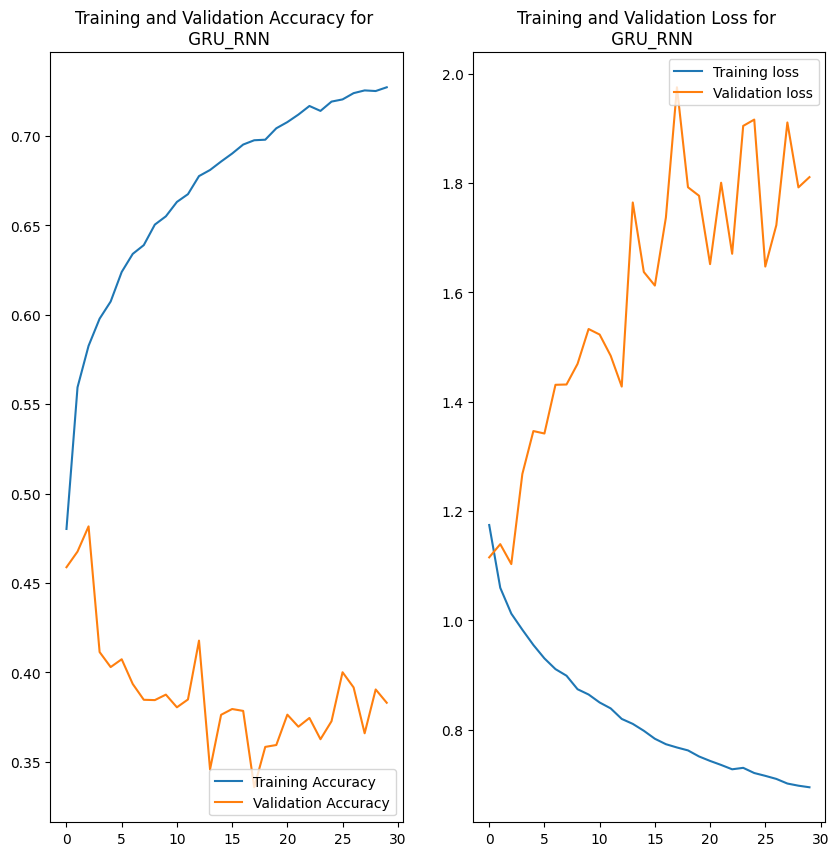

In [62]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc_rnn,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc_rnn,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for \n GRU_RNN')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss_rnn,label='Training loss')
plt.plot(range(EPOCHS),val_loss_rnn,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for \n GRU_RNN')

In [64]:
model_rnn.save('model_cnn_gru.h5')